In [1]:
import psycopg2
import pandas as pd
import os
import datetime as dt
import numpy as np
import sys

In [61]:
import script as sc

# ensure all columns are displayed when viewing a pandas dataframe
pd.set_option('display.max_columns', None)

In [10]:
def make_csv(query, filename):
   
    # check if file already exists
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    # ensure all columns are displayed when viewing a pandas dataframe
    pd.set_option('display.max_columns', None)
    
    # Creating a connection to the database
    print("creating connection...")
    con = psycopg2.connect(database="mid_term_project", 
                           user="lhl_student", 
                           password="lhl_student", 
                           host="lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com", 
                           port="5432")


    # creating a cursor object
    cur = con.cursor()
    # running an sql query
    print("running query...")
    cur.execute(query)
    # Storing the result
    rows = cur.fetchall()
    cols = [desc[0] for desc in cur.description]

    con.close()

    # writing the csv file
    print("writing file...")
    df = pd.DataFrame(rows, columns=cols)
    df.to_csv(filename, index=False)
    
    print('Done')
    
    return df

# Flights Table Feature Engineering

### List of columns I think are not important, redundant or not allowed
- 'dep_delay', 'arr_delay', 'nad_delay', 'security_delay', 'late_aircraft_delay', 'carrier_delay', 'weather_delay' - not allowed
- 'origin_city_name' and 'origin' - we already know the airport from feature 'origin_airport_id'
- 'dest_city_name' and 'dest' - already know airport from feature 'dest_airport_id'
- 'no_name' - not in data dictionary and all null values


### Columns i think can be modified to show pertenant info
- 'taxi_in' and 'taxi_out' find 'total_taxi'
- 'wheels_on' and 'wheels_off' find 'total_wheel'
- 'cancellation_code' - deterine which codes are for avoidable delays - (not including weather as we have no weather data... yet)
- 'fl_date' determine which flights left on which day of week - determine if weekend had more delays and so on
- 

In [41]:
# will create file in place of ipynb file
test = make_csv("SELECT * FROM flights LIMIT 1000", "test1000flight.csv")

creating connection...
running query...
writing file...
Done


In [27]:
def unique_values(df):
    for i in range(len(df.columns)):
        unique =  df.iloc[:, i].unique()
        print(i, unique)
    return

In [51]:
test.head()

,fl_date,op_carrier_fl_num,origin_airport_id,dest_airport_id,taxi_out,wheels_off,wheels_on,taxi_in,diverted,air_time,distance,total_delay
0,2019-09-27,5274,10713,13930,16.0,1221.0,1632.0,12.0,0.0,191.0,1437.0,1
1,2019-09-27,5275,11292,15376,11.0,1911.0,1948.0,4.0,0.0,97.0,639.0,0
2,2019-09-27,5276,14698,12892,12.0,621.0,703.0,14.0,0.0,42.0,156.0,0
3,2019-09-27,5277,11540,11292,18.0,1042.0,1211.0,7.0,0.0,89.0,563.0,0
4,2019-09-27,5278,10434,13930,20.0,205.0,259.0,9.0,0.0,114.0,632.0,0


In [133]:
unique_values(test)

0 ['2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15' '2018-01-16'
 '2018-01-22' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-27'
 '2018-01-26' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-08-01' '2018-08-02' '2018-08-03' '2018-08-04' '2018-08-05'
 '2018-08-06' '2018-08-07' '2018-08-08' '2018-08-09' '2018-08-10'
 '2018-08-11' '2018-08-12' '2018-08-13' '2018-08-14' '2018-08-15'
 '2018-08-16' '2018-08-17' '2018-08-19' '2018-08-18' '2018-08-20'
 '2018-08-21' '2018-08-23' '2018-08-22' '2018-08-24' '2018-08-29'
 '2018-08-25' '2018-08-26' '2018-08-27' '2018-08-28']
1 ['UA' 'DL' 'HA' 'NK' 'AA' 'WN' 'AS' 'G4' 'VX' 'B6' 'F9']
2 ['UA' 'DL_CODESHARE' 'HA' 'NK' 'AA_CODESHARE' 'WN' 'UA_CODESHARE' 'AA'
 'AS' 'AS_CODESHARE' 'DL' 'G4' 'VX' 'B6' 'F9' 'HA_CODESHARE']
3 ['UA' 'DL' 'HA' 'NK' 'AA' 'WN' 'AS' 'G4' 'VX' 'B6' 'F9']
4 [ 206  205  204 ... 1032 6329 6377]
5 ['UA' '9E' 'HA' 'NK' 'OH' 'WN' 'YX' 'AA' 'AX' 'PT' 'CP' '

In [43]:
test = test.drop(['dep_delay', 'arr_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'carrier_delay', 'weather_delay', 'no_name'], axis = 1)

In [44]:
test = test.drop(['mkt_carrier', 'branded_code_share', 'origin_city_name', 'origin', 'dest', 'dest_city_name'], axis = 1)

In [45]:
test['crs_dep_time'] = test['crs_dep_time'].astype('float64')
test['crs_arr_time'] = test['crs_arr_time'].astype('float64')

In [46]:
test['total_delay'] = (test['dep_time'] - test['crs_dep_time']) + (test['arr_time'] - test['crs_arr_time']) + (test['actual_elapsed_time'] - test['crs_elapsed_time'])

In [47]:
test = test.drop(['dep_time', 'crs_dep_time', 'arr_time', 'crs_arr_time', 'actual_elapsed_time', 'crs_elapsed_time'], axis = 1)

In [48]:
test = test.drop(['dup', 'cancelled', 'cancellation_code', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num', 'op_unique_carrier'], axis = 1)

In [49]:
test['total_delay'] = test['total_delay'].apply(lambda x: 0 if x < 0 else 1)

In [50]:
test = test.dropna()

In [33]:
def date_to_dtday(df, feature, form = 'day'):
    '''
    set date column to either binary or datetime numeric 
    '''
    df[feature] =  pd.to_datetime(test['fl_date'], format='%Y-%m-%d')
    df[feature] = df[feature].dt.day_of_week
    if form == 'binary':
        df.loc[df[feature] <= 4, feature] = 0
        df.loc[df[feature] > 4, feature] = 1
    return df

In [62]:
test = date_to_dtday(test, 'fl_date', 'binary')

In [63]:
test = test.astype('float32')
test['total_delay'] = test['total_delay'].astype('int')
test = test.reset_index()
test = test.drop('index', axis = 1)

In [64]:
test.head()

,fl_date,op_carrier_fl_num,origin_airport_id,dest_airport_id,taxi_out,wheels_off,wheels_on,taxi_in,diverted,air_time,distance,total_delay
0,0.0,5274.0,10713.0,13930.0,16.0,1221.0,1632.0,12.0,0.0,191.0,1437.0,1
1,0.0,5275.0,11292.0,15376.0,11.0,1911.0,1948.0,4.0,0.0,97.0,639.0,0
2,0.0,5276.0,14698.0,12892.0,12.0,621.0,703.0,14.0,0.0,42.0,156.0,0
3,0.0,5277.0,11540.0,11292.0,18.0,1042.0,1211.0,7.0,0.0,89.0,563.0,0
4,0.0,5278.0,10434.0,13930.0,20.0,205.0,259.0,9.0,0.0,114.0,632.0,0


In [65]:
test.tail()

,fl_date,op_carrier_fl_num,origin_airport_id,dest_airport_id,taxi_out,wheels_off,wheels_on,taxi_in,diverted,air_time,distance,total_delay
927,0.0,2276.0,11298.0,12266.0,14.0,1647.0,1729.0,12.0,0.0,42.0,224.0,1
928,0.0,2276.0,12266.0,11298.0,16.0,1849.0,1932.0,7.0,0.0,43.0,224.0,0
929,0.0,2278.0,11278.0,13303.0,26.0,1026.0,1231.0,5.0,0.0,125.0,919.0,0
930,0.0,2278.0,13303.0,11278.0,14.0,636.0,838.0,3.0,0.0,122.0,919.0,0
931,0.0,2279.0,12892.0,13204.0,10.0,1506.0,2220.0,8.0,0.0,254.0,2218.0,0


In [745]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fl_date              10000 non-null  int64  
 1   mkt_unique_carrier   10000 non-null  object 
 2   branded_code_share   10000 non-null  object 
 3   mkt_carrier          10000 non-null  object 
 4   mkt_carrier_fl_num   10000 non-null  int64  
 5   op_unique_carrier    10000 non-null  object 
 6   tail_num             9991 non-null   object 
 7   op_carrier_fl_num    10000 non-null  int64  
 8   origin_airport_id    10000 non-null  int64  
 9   origin               10000 non-null  object 
 10  origin_city_name     10000 non-null  object 
 11  dest_airport_id      10000 non-null  int64  
 12  dest                 10000 non-null  object 
 13  dest_city_name       10000 non-null  object 
 14  crs_dep_time         10000 non-null  int64  
 15  dep_time             9848 non-null   

features to add to target columns
- crs_dep_time, dep_time, arr_time, crs_arr_time, actual_elapsed_time, crs_elapsed_time, wheels_off, wheels_on, taxi_in, taxi_out

In [66]:
test['total_delay'].sum()

320

### Flights Table Rough Testing

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

In [68]:
y_col = 'total_delay'
y = test[y_col]
X = test[test.columns.drop(y_col)]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [70]:
clf = LogisticRegression(penalty = 'none')

clf.fit(X, y)

/Users/george/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

In [73]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7214285714285714


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.90      0.81       182
           1       0.68      0.39      0.49        98

    accuracy                           0.72       280
   macro avg       0.71      0.64      0.65       280
weighted avg       0.71      0.72      0.70       280



In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.6571428571428571


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       182
           1       0.52      0.30      0.38        98

    accuracy                           0.66       280
   macro avg       0.60      0.57      0.57       280
weighted avg       0.63      0.66      0.63       280



In [77]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [78]:
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [79]:
xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

[17:20:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [80]:
y_pred

array([0.43146244, 0.32706714, 0.32706714, 0.32706714, 0.41424805,
       0.440963  , 0.45812273, 0.43146244, 0.45766598, 0.47173876,
       0.4382421 , 0.464002  , 0.37905183, 0.36224753, 0.45766598,
       0.36971408, 0.37975073, 0.39023834, 0.43130636, 0.32706714,
       0.42909178, 0.35060644, 0.44774267, 0.36040094, 0.37905183,
       0.4649024 , 0.4382988 , 0.4223121 , 0.42225543, 0.32706714,
       0.42225543, 0.34571803, 0.44713023, 0.43808603, 0.4223121 ,
       0.36971408, 0.32706714, 0.43412665, 0.42909178, 0.44510883,
       0.32706714, 0.4813491 , 0.43146244, 0.43412665, 0.42225543,
       0.34691125, 0.41424805, 0.45766598, 0.3464169 , 0.3464169 ,
       0.41874033, 0.38209164, 0.45207417, 0.46450233, 0.32706714,
       0.36971408, 0.32706714, 0.37975073, 0.43146244, 0.41547576,
       0.49322033, 0.43972164, 0.44995725, 0.32706714, 0.32706714,
       0.45812273, 0.43412665, 0.42225543, 0.46797386, 0.4382988 ,
       0.5064362 , 0.34571803, 0.32706714, 0.49055612, 0.34641

In [81]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [82]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %f' % (rmse))

RMSE: 0.475962


In [83]:
params = {"objective":"reg:linear", 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[17:21:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.493200,0.000509,0.494557,0.000466
1,0.486763,0.001991,0.490407,0.000444
2,0.481149,0.002331,0.485648,0.002141
3,0.476487,0.002980,0.482250,0.002279
4,0.471423,0.001965,0.478799,0.001427


In [85]:
print((cv_results['test-rmse-mean']).tail(1))

49    0.443589
Name: test-rmse-mean, dtype: float64


In [86]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[17:21:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


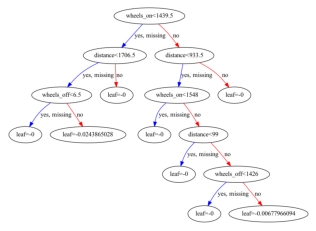

In [87]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 15]
plt.show()

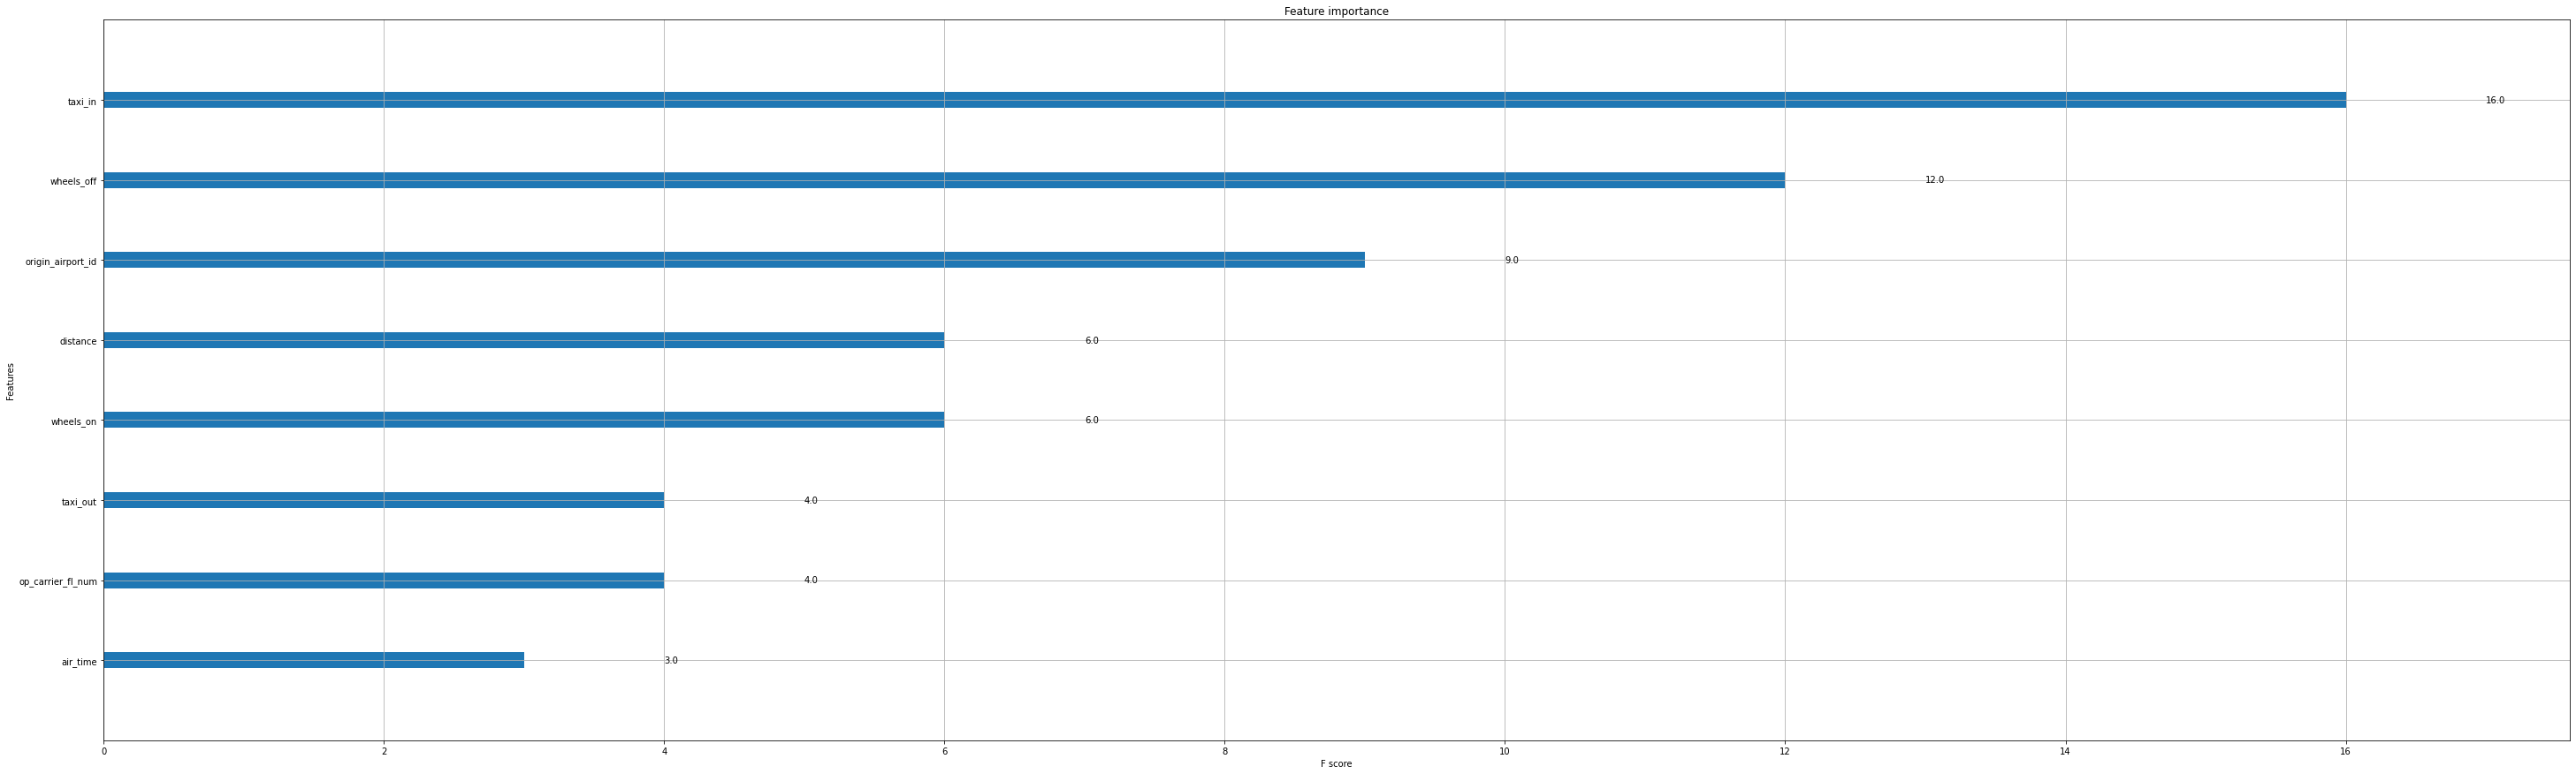

In [88]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
chart = plt.gcf()
plt.show()
chart.savefig('chart.png', dpi = 100)

# Passenger Table Feature Engineering

In [45]:
pas = make_csv("SELECT * FROM passengers LIMIT 10000", "test10000pass.csv")

creating connection...
running query...
writing file...
Done


In [46]:
pas.head()

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,unique_carrier,airline_id,unique_carrier_name,region,carrier,carrier_name,carrier_group,carrier_group_new,origin_airport_id,origin_city_market_id,origin,origin_city_name,origin_country,origin_country_name,dest_airport_id,dest_city_market_id,dest,dest_city_name,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
0,3.0,1.0,39600.0,159.0,157.0,0.0,720.0,2520.0,302.0,268.0,AS,19930,Alaska Airlines Inc.,D,AS,Alaska Airlines Inc.,3,3,14747,30559,SEA,"Seattle, WA",US,United States,15304,33195,TPA,"Tampa, FL",US,United States,6,614,1,2018,3,6,F,DU
1,3.0,3.0,137500.0,534.0,381.0,34.0,0.0,2548.0,976.0,890.0,AS,19930,Alaska Airlines Inc.,D,AS,Alaska Airlines Inc.,3,3,14831,32457,SJC,"San Jose, CA",US,United States,11618,31703,EWR,"Newark, NJ",US,United States,6,888,1,2018,3,6,F,DU
2,3.0,4.0,136300.0,496.0,392.0,1259.0,0.0,689.0,483.0,396.0,AS,19930,Alaska Airlines Inc.,D,AS,Alaska Airlines Inc.,3,3,14869,34614,SLC,"Salt Lake City, UT",US,United States,14747,30559,SEA,"Seattle, WA",US,United States,6,612,1,2018,3,2,F,DU
3,3.0,2.0,79500.0,318.0,303.0,0.0,0.0,2520.0,803.0,751.0,AS,19930,Alaska Airlines Inc.,D,AS,Alaska Airlines Inc.,3,3,15304,33195,TPA,"Tampa, FL",US,United States,14747,30559,SEA,"Seattle, WA",US,United States,6,614,1,2018,3,6,F,DU
4,3.0,2.0,80100.0,0.0,0.0,30450.0,1054.0,198.0,133.0,68.0,AS,19930,Alaska Airlines Inc.,D,AS,Alaska Airlines Inc.,3,3,15991,35991,YAK,"Yakutat, AK",US,United States,12523,32523,JNU,"Juneau, AK",US,United States,6,612,2,2018,3,1,G,DU


In [969]:
pas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   departures_scheduled   10000 non-null  float64
 1   departures_performed   10000 non-null  float64
 2   payload                10000 non-null  float64
 3   seats                  10000 non-null  float64
 4   passengers             10000 non-null  float64
 5   freight                10000 non-null  float64
 6   mail                   10000 non-null  float64
 7   distance               10000 non-null  float64
 8   ramp_to_ramp           10000 non-null  float64
 9   air_time               10000 non-null  float64
 10  unique_carrier         10000 non-null  object 
 11  airline_id             10000 non-null  int64  
 12  unique_carrier_name    10000 non-null  object 
 13  region                 10000 non-null  object 
 14  carrier                10000 non-null  object 
 15  car

In [948]:
unique_values(pas)

0 [ 0. 12.]
1 [  3.   1.  31.  14.   5.   2.   6.  26.  43.   9.  18.  30.   8.  38.
  10.  17.   4.  42.  15.  52.  60.   7.  46.  54.  11.  27.  13.  22.
  12.  32.  16.  61.  20.  45.  25.  44.  24.  21.  47.  33.  19.  37.
  23.  29.  28. 300.  34.  39.  40.  51.  50.  41. 297.  49.  36. 103.
  92.   0.  35. 363.  48.  59. 364.  62.  58.  83. 143.  90.  82. 114.
 106. 124. 105. 107. 147.  73.  93.  71. 128. 157.  56. 129.  78. 110.
  84. 138. 183.  74.  79.  64.  53.  55. 108. 109. 115.  63.  85. 100.
  96.  91.  97.  99. 101. 276. 120. 278.  75.  76. 238.  77. 237. 102.
 260.  80. 117. 259. 119. 122.  72.  70.  69.  86.  89. 142.  66.  65.
 197. 200. 186. 185. 116. 132. 160. 337. 156.  57. 149. 150. 104. 151.]
2 [ 10200.   3500. 107300. ...  37500.  13500.  97500.]
3 [2.700e+01 9.000e+00 2.790e+02 ... 2.409e+03 9.687e+03 7.504e+03]
4 [  10.    9.  131. ... 5116.  967. 1004.]
5 [ 580.    0.  177. ...  765.  321. 5652.]
6 [   0.  365.  144. ... 1423. 3432. 2338.]
7 [  19.  113.    0

### List of columns I think are not important, redundant or not allowed
- 'dest_city_market_id', 'dest_city_name', 'dest_country', 'dest_country_code', 'dest', 'origin_city_market_id', 'origin_city_name', 'origin_country', 'origin_country_name', 'year', 'distance_group', 'distance', 'carrier_group', 'region', 'carrier_name', 'carrier_group', 'data_source', 'carrier', 'unique_carrier_name', 'seats',  

- 'month' if we are not looking at weather

### Columns i think can be modified to show pertenant info
- 'departures_schedules'
- 'mail', 'freight_transported' - determine if adding cargo along with passengers / their belongings contributes to delay
- 'class' - depends if it means the highest seating class available or if the plane itself is classified as something based on the make up - F and A: first class, C, J, R, D and I: business class, W and P: premium economy, Y, H, K, M, L, G, V, S, N, Q, O and E: economy, B: basic economy.
- 'unique_carrier' - set to nmuerical value

def set_class_grouping(df, feature):
    
    df.loc[(df[feature] == 'F', feature) or (df[feature] == 'A')] = 0
    df.loc[(df[feature] == 'C') or (df[feature] == 'J') or (df[feature] == 'R') or (df[feature] == 'D') or (df[feature] == 'I')] = 1
    df.loc[(df[feature] == 'W') or (df[feature] == 'P')] = 2
    df.loc[(df[feature] == 'Y') or (df[feature] == 'K') or (df[feature] == 'M') or (df[feature] == 'L') or (df[feature] == 'G') or (df[feature] == 'V') or (df[feature] == 'S') or (df[feature] == 'N') or (df[feature] == 'Q') or (df[feature] == 'O') or (df[feature] == 'E')] = 3
    df.loc[df[feature] == 'B'] = 0
    
    return df.head()

In [47]:
pas = pas.drop(['dest_city_market_id', 'dest_city_name', 'dest_country', 'dest_country_name', 'dest', 
                'origin_city_market_id', 'origin', 'origin_city_name', 'origin_country', 'origin_country_name', 
                'year', 'month', 'distance_group', 'distance', 'region', 'carrier_name', 'carrier_group', 
                'data_source', 'carrier', 'unique_carrier_name', 'seats'], axis = 1)               

In [48]:
def set_class_grouping(df, feature):
    '''
    set class values for class feature - highly specific, only to be used for iterations of passenger table
    '''
    df.loc[df[feature] == 'A', feature] = 0
    df.loc[df[feature] == 'F', feature] = 0
    df.loc[df[feature] == 'C', feature] = 1
    df.loc[df[feature] == 'J', feature] = 1
    df.loc[df[feature] == 'R', feature] = 1
    df.loc[df[feature] == 'D', feature] = 1
    df.loc[df[feature] == 'I', feature] = 1
    df.loc[df[feature] == 'W', feature] = 2
    df.loc[df[feature] == 'P', feature] = 2
    df.loc[df[feature] == 'Y', feature] = 3
    df.loc[df[feature] == 'K', feature] = 3
    df.loc[df[feature] == 'M', feature] = 3
    df.loc[df[feature] == 'L', feature] = 3
    df.loc[df[feature] == 'G', feature] = 3
    df.loc[df[feature] == 'V', feature] = 3
    df.loc[df[feature] == 'S', feature] = 3
    df.loc[df[feature] == 'N', feature] = 4
    df.loc[df[feature] == 'Q', feature] = 4
    df.loc[df[feature] == 'O', feature] = 4
    df.loc[df[feature] == 'E', feature] = 4
    df.loc[df[feature] == 'B', feature] = 5
    return df.head()

In [49]:
set_class_grouping(pas, 'class')

,departures_scheduled,departures_performed,payload,passengers,freight,mail,ramp_to_ramp,air_time,unique_carrier,airline_id,carrier_group_new,origin_airport_id,dest_airport_id,aircraft_group,aircraft_type,aircraft_config,class
0,3.0,1.0,39600.0,157.0,0.0,720.0,302.0,268.0,AS,19930,3,14747,15304,6,614,1,0
1,3.0,3.0,137500.0,381.0,34.0,0.0,976.0,890.0,AS,19930,3,14831,11618,6,888,1,0
2,3.0,4.0,136300.0,392.0,1259.0,0.0,483.0,396.0,AS,19930,3,14869,14747,6,612,1,0
3,3.0,2.0,79500.0,303.0,0.0,0.0,803.0,751.0,AS,19930,3,15304,14747,6,614,1,0
4,3.0,2.0,80100.0,0.0,30450.0,1054.0,133.0,68.0,AS,19930,3,15991,12523,6,612,2,3


unique_vals = pas['unique_carrier'].unique()
pas['unique_carrier'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)

In [50]:
def replace_with_numeric(df, column):
    '''
    input the data frame and the column to repalace the unique values with numeric values
    '''
    unique_vals = df[column].unique()
    df[column].replace(to_replace=unique_vals,
                                  value= list(range(len(unique_vals))),
                                  inplace=True)
    return

In [51]:
replace_with_numeric(pas, 'unique_carrier')

In [53]:
pas.head()

,departures_scheduled,departures_performed,payload,passengers,freight,mail,ramp_to_ramp,air_time,unique_carrier,airline_id,carrier_group_new,origin_airport_id,dest_airport_id,aircraft_group,aircraft_type,aircraft_config,class
0,3.0,1.0,39600.0,157.0,0.0,720.0,302.0,268.0,0,19930,3,14747,15304,6,614,1,0
1,3.0,3.0,137500.0,381.0,34.0,0.0,976.0,890.0,0,19930,3,14831,11618,6,888,1,0
2,3.0,4.0,136300.0,392.0,1259.0,0.0,483.0,396.0,0,19930,3,14869,14747,6,612,1,0
3,3.0,2.0,79500.0,303.0,0.0,0.0,803.0,751.0,0,19930,3,15304,14747,6,614,1,0
4,3.0,2.0,80100.0,0.0,30450.0,1054.0,133.0,68.0,0,19930,3,15991,12523,6,612,2,3


In [54]:
pas['unique_carrier'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

# Flights Table Feature Engineering

List of columns I think are not important, redundant or not allowed
- 'unique_carrier', 'carrier', 'carrier_name', 'carrier_group_new', 'sdmont_gallons', 'satl_gallons', 'spac_gallons', 'slat_gallons', 'sint_gallons', 'ts_gallons', 'tdomt_gallons', 'tint_gallons', 'sdomt_cost', 'satl_cost', 'spac_cost', 'slat_cost', 'sint_cost', 'ts_cost', 'tdomt_cost', 'tint_cost', 'total_cost', 'year'

Columns I think can be modified to show pertenant info
- 'total_gallons' - bin since each plane could have drastically diff amount, check unique values - determine if larget fuel amount leads to greater delay

In [679]:
fuel = make_csv("SELECT * FROM fuel_comsumption LIMIT 10000", "test10000fuel.csv")

In [680]:
fuel.head()

,month,airline_id,unique_carrier,carrier,carrier_name,carrier_group_new,sdomt_gallons,satl_gallons,spac_gallons,slat_gallons,sint_gallons,ts_gallons,tdomt_gallons,tint_gallons,total_gallons,sdomt_cost,satl_cost,spac_cost,slat_cost,sint_cost,ts_cost,tdomt_cost,tint_cost,total_cost,year
0,1,NaN,NaN,0JQ,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,5100.0,0.0,5100.0,2016
1,1,21352.0,0WQ,0WQ,Avjet Corporation,1,0.0,0.0,0.0,0.0,0.0,0.0,163052.0,47060.0,210112.0,0.0,0.0,0.0,0.0,0.0,0.0,396216.0,140239.0,536455.0,2016
2,1,21645.0,23Q,23Q,Songbird Airways Inc.,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
3,1,21652.0,27Q,27Q,"Jet Aviation Flight Services, Inc.",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
4,1,20408.0,5V,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,1,260848.0,0.0,0.0,0.0,0.0,260848.0,284362.0,0.0,284362.0,522405.0,0.0,0.0,0.0,0.0,522405.0,569497.0,0.0,569497.0,2016


In [681]:
fuel = fuel.drop(['unique_carrier', 'carrier', 'carrier_name', 'carrier_group_new', 
                  'sdomt_gallons', 'satl_gallons', 'spac_gallons', 'slat_gallons', 'sint_gallons', 
                  'ts_gallons', 'tdomt_gallons', 'sdomt_cost', 'satl_cost', 'spac_cost', 'slat_cost', 
                  'sint_cost', 'ts_cost', 'tdomt_cost', 'tint_cost', 'total_cost', 'year', 'tint_gallons'], axis = 1)

In [682]:
fuel.head()

,month,airline_id,total_gallons
0,1,NaN,3000.0
1,1,21352.0,210112.0
2,1,21645.0,0.0
3,1,21652.0,0.0
4,1,20408.0,284362.0


In [740]:
def xgboost(X_train = X_train, y_train = y_train, n_estimators = 10, max_depth = 5, alpha = 10, num_boost_round = 50):
    '''
    Set the params for XGBoost and perform corss validation by K-folds method, will eventually split the functions for more specificity
    '''
    xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = max_depth, alpha = alpha, n_estimators = n_estimators)
    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('RMSE: %f' % (rmse))
    
    params = {"objective":"reg:linear", 'colsample_bytree': 0.3, 
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                        num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmse", 
                        as_pandas=True, seed=123)
    
    print(cv_results)
    return

In [738]:
xgboost()

[13:22:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.483567
[13:22:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.497200        0.000047        0.497588       0.000224
1          0.495415

In [727]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[13:17:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


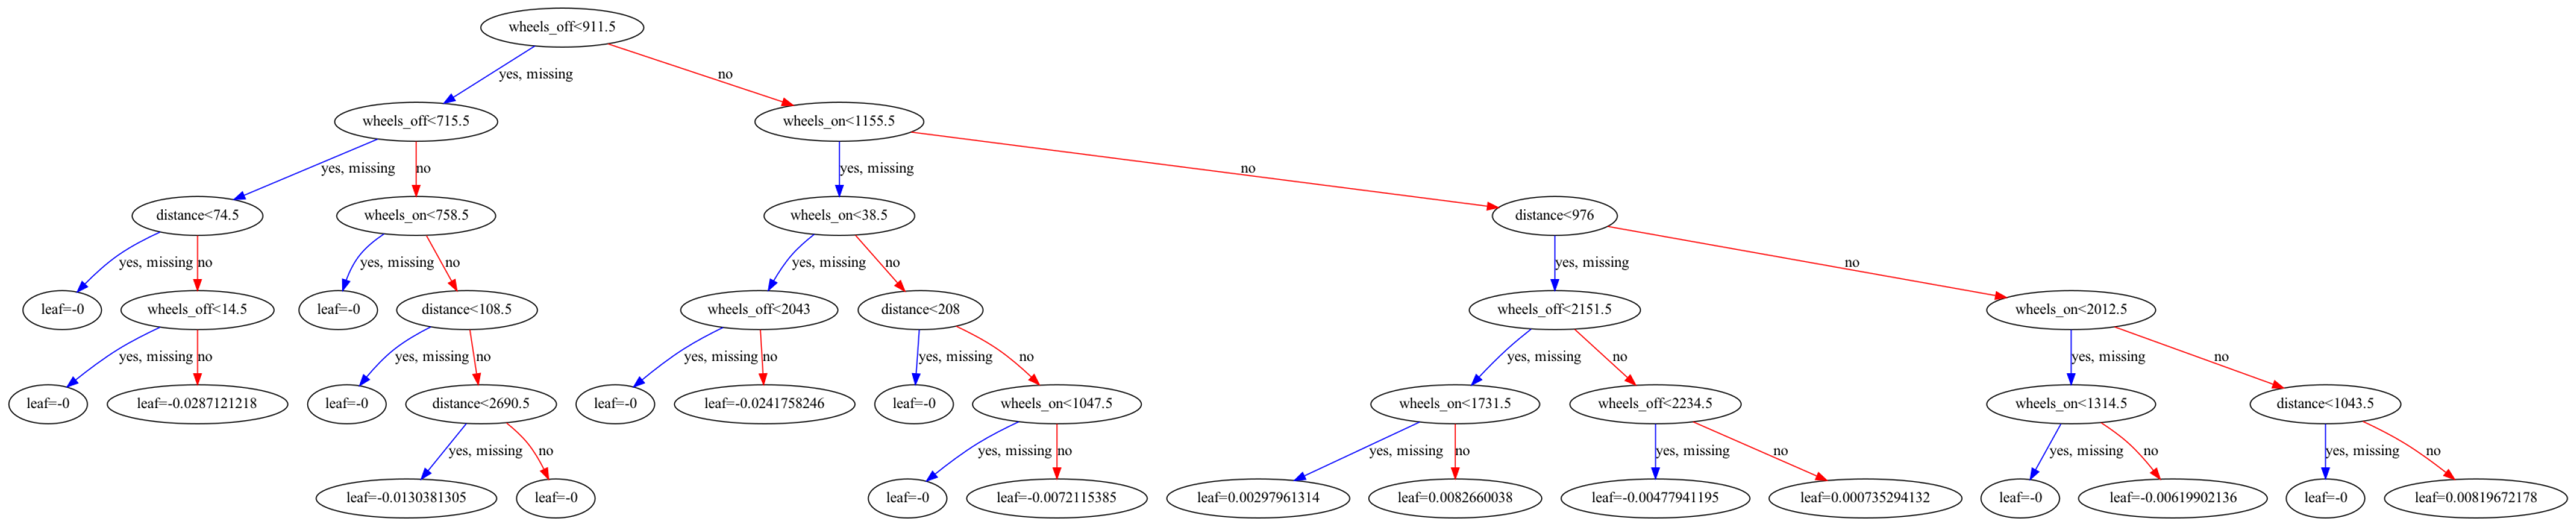

In [728]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 15]
plt.show()

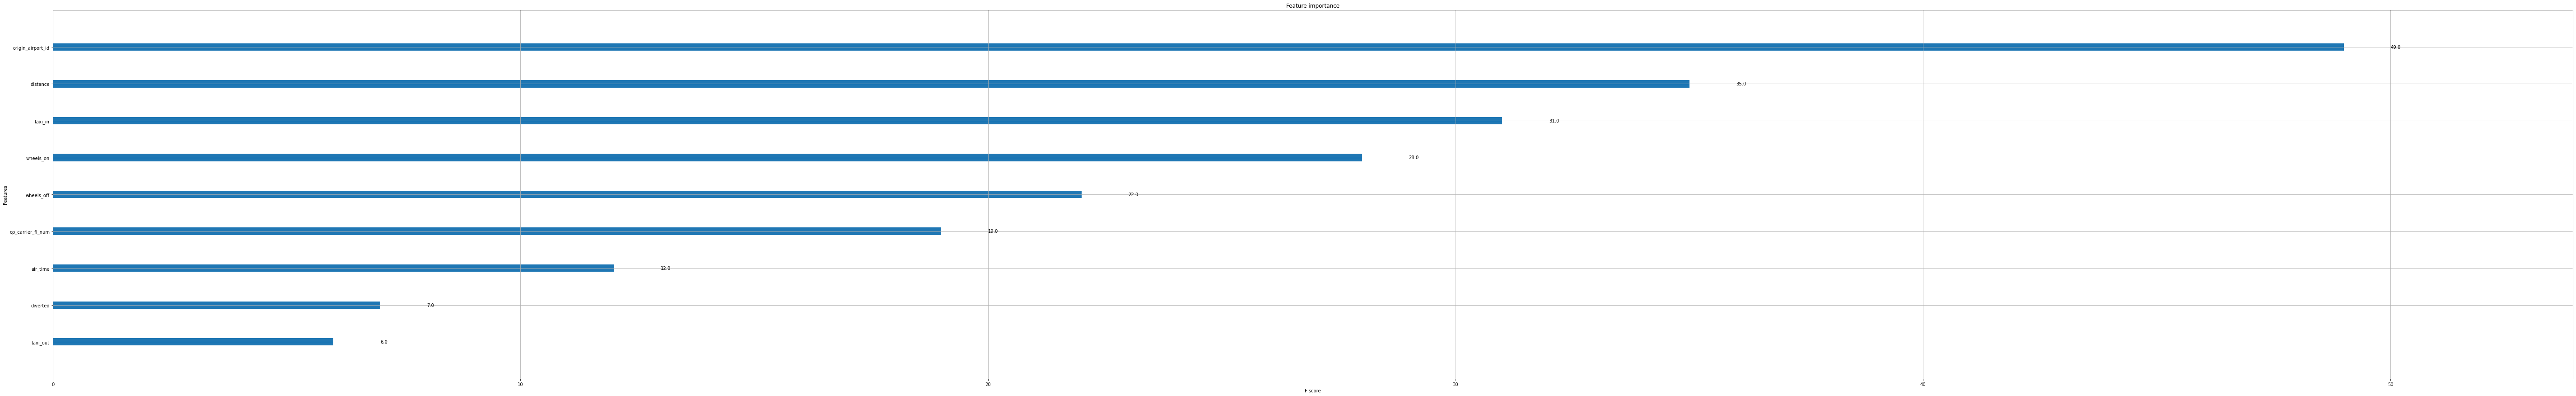

In [729]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [1081]:
test = make_csv("SELECT * FROM flights LIMIT 10000", "test10000flight1.csv")
test

creating connection...
running query...
writing file...
Done


,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-04-06,AS,AS,AS,190,AS,N611AS,190,11630,FAI,"Fairbanks, AK",10299,ANC,"Anchorage, AK",1540,1531.0,-9.0,8.0,1539.0,1624.0,4.0,1637,1628.0,-9.0,0.0,None,0.0,N,57.0,57.0,45.0,1.0,261.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2018-04-06,AS,AS,AS,191,AS,N538AS,191,10299,ANC,"Anchorage, AK",11630,FAI,"Fairbanks, AK",900,853.0,-7.0,9.0,902.0,942.0,3.0,954,945.0,-9.0,0.0,None,0.0,N,54.0,52.0,40.0,1.0,261.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2018-04-06,AS,AS,AS,192,AS,N538AS,192,11630,FAI,"Fairbanks, AK",10299,ANC,"Anchorage, AK",1100,1049.0,-11.0,10.0,1059.0,1145.0,4.0,1159,1149.0,-10.0,0.0,None,0.0,N,59.0,60.0,46.0,1.0,261.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2018-04-06,AS,AS,AS,194,AS,N611AS,194,11630,FAI,"Fairbanks, AK",10299,ANC,"Anchorage, AK",1940,1928.0,-12.0,9.0,1937.0,2021.0,3.0,2039,2024.0,-15.0,0.0,None,0.0,N,59.0,56.0,44.0,1.0,261.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2018-04-06,AS,AS,AS,195,AS,N611AS,195,10299,ANC,"Anchorage, AK",11630,FAI,"Fairbanks, AK",1349,1340.0,-9.0,8.0,1348.0,1425.0,3.0,1444,1428.0,-16.0,0.0,None,0.0,N,55.0,48.0,37.0,1.0,261.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018-04-07,UA,UA_CODESHARE,UA,5596,OO,N983SW,5596,11267,DAY,"Dayton, OH",13930,ORD,"Chicago, IL",1825,1816.0,-9.0,26.0,1842.0,1827.0,10.0,1849,1837.0,-12.0,0.0,None,0.0,N,84.0,81.0,45.0,1.0,240.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
9996,2018-04-07,UA,UA_CODESHARE,UA,5597,OO,N969SW,5597,11423,DSM,"Des Moines, IA",11292,DEN,"Denver, CO",1305,1257.0,-8.0,11.0,1308.0,1349.0,7.0,1405,1356.0,-9.0,0.0,None,0.0,N,120.0,119.0,101.0,1.0,589.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
9997,2018-04-07,UA,UA_CODESHARE,UA,5598,OO,N206SY,5598,12441,JAC,"Jackson, WY",12892,LAX,"Los Angeles, CA",1745,1733.0,-12.0,11.0,1744.0,1902.0,8.0,1918,1910.0,-8.0,0.0,None,0.0,N,153.0,157.0,138.0,1.0,784.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
9998,2018-04-07,UA,UA_CODESHARE,UA,5600,OO,N792SK,5600,12892,LAX,"Los Angeles, CA",14771,SFO,"San Francisco, CA",2131,2136.0,5.0,27.0,2203.0,2300.0,6.0,2302,2306.0,4.0,0.0,None,0.0,N,91.0,90.0,57.0,1.0,337.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [1094]:
'''
FROM * SELECT flights
WHERE 'fl_date' BETWEEN '2019-01-01' and '2019-02-01'
LIMIT 1000
'''

date = make_csv("SELECT * FROM flights WHERE fl_date BETWEEN '2018-04-08' AND '2018-04-09' LIMIT 100000", 'date_test0.csv')

creating connection...
running query...
writing file...
Done


In [1095]:
date

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-04-08,AA,AA_CODESHARE,AA,5265,OH,N563NN,5265,11057,CLT,"Charlotte, NC",10397,ATL,"Atlanta, GA",1600,1610.0,10.0,22.0,1632.0,1717.0,4.0,1714,1721.0,7.0,0.0,None,0.0,N,74.0,71.0,45.0,1.0,226.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2018-04-08,AA,AA_CODESHARE,AA,5266,OH,N584NN,5266,11057,CLT,"Charlotte, NC",14576,ROC,"Rochester, NY",1250,1247.0,-3.0,14.0,1301.0,1429.0,3.0,1442,1432.0,-10.0,0.0,None,0.0,N,112.0,105.0,88.0,1.0,573.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2018-04-08,AA,AA_CODESHARE,AA,5266,OH,N584NN,5266,14576,ROC,"Rochester, NY",11057,CLT,"Charlotte, NC",1512,1502.0,-10.0,11.0,1513.0,1651.0,24.0,1726,1715.0,-11.0,0.0,None,0.0,N,134.0,133.0,98.0,1.0,573.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2018-04-08,AA,AA_CODESHARE,AA,5268,OH,N584NN,5268,11057,CLT,"Charlotte, NC",11193,CVG,"Cincinnati, OH",755,752.0,-3.0,33.0,825.0,923.0,6.0,923,929.0,6.0,0.0,None,0.0,N,88.0,97.0,58.0,1.0,335.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2018-04-08,AA,AA_CODESHARE,AA,5270,OH,N559NN,5270,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",650,642.0,-8.0,8.0,650.0,925.0,26.0,1019,951.0,-28.0,0.0,None,0.0,N,149.0,129.0,95.0,1.0,815.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44189,2018-04-08,AS,AS,AS,327,AS,N551AS,327,14831,SJC,"San Jose, CA",14747,SEA,"Seattle, WA",900,852.0,-8.0,22.0,914.0,1119.0,7.0,1106,1126.0,20.0,0.0,None,0.0,N,126.0,154.0,125.0,1.0,696.0,0.0,0.0,20.0,0.0,0.0,None,NaN,NaN,None
44190,2018-04-08,AS,AS,AS,328,AS,N224AK,328,14747,SEA,"Seattle, WA",14893,SMF,"Sacramento, CA",955,950.0,-5.0,28.0,1018.0,1135.0,5.0,1142,1140.0,-2.0,0.0,None,0.0,N,107.0,110.0,77.0,1.0,605.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
44191,2018-04-08,AS,AS,AS,330,AS,N435AS,330,14747,SEA,"Seattle, WA",14831,SJC,"San Jose, CA",1343,1340.0,-3.0,14.0,1354.0,1531.0,4.0,1548,1535.0,-13.0,0.0,None,0.0,N,125.0,115.0,97.0,1.0,696.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
44192,2018-04-08,AS,AS,AS,333,AS,N532AS,333,14679,SAN,"San Diego, CA",14057,PDX,"Portland, OR",620,617.0,-3.0,36.0,653.0,916.0,4.0,900,920.0,20.0,0.0,None,0.0,N,160.0,183.0,143.0,1.0,933.0,0.0,0.0,20.0,0.0,0.0,None,NaN,NaN,None


In [15]:
def print_scores(y_test, y_pred, y_prob):
    '''
    Print prediction scores.
    
    Parameters
    ----------
    y_test
        target test data
    y_pred
        target predictions
    y_prob
        target prediction probabilities
    
    Returns
    -------
    prints
        1. Confusion Matrix
        2. Recall Score
            TP / (TP + FN)
        3. Precision Score
            TP / (TP + FP)
        4. F1 Score
            2 * precision * recall / (precision + recall)
        5. Accuracy Score
            (TP + TN) / (TP + FP + TN + FN)
        6. ROC-AUC
            TPR vs FPR curve, scored by area under curve
    graphs
        ROC Curve Graph
    '''
    
    # import libraries
    from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
    from sklearn.metrics import RocCurveDisplay
    
    # confusion matrix
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    
    print('\n--------SCORES---------\n')
    
    # recall scores
    try:
        print('1. Recall Score: ', recall_score(y_test,y_pred))
    except ValueError:
        print('1. Recall Score (multiclass micro)', recall_score(y_test,y_pred, average='micro'))
        print('1. Recall Score (multiclass macro)', recall_score(y_test,y_pred, average='macro'))
    
    # precision scores
    try:
        print('2. Precision Score: ', recall_score(y_test,y_pred))
    except ValueError:
        print('2. Precision Score (multiclass micro)', precision_score(y_test,y_pred, average='micro'))
        print('2. Precision Score (multiclass macro)', precision_score(y_test,y_pred, average='macro'))

    # f1 scores
    try:
        print('3. F1 Score: ', f1_score(y_test,y_pred))
    except ValueError:
        print('3. F1 Score (multiclass micro)', f1_score(y_test,y_pred, average='micro'))
        print('3. F1 Score (multiclass macro)', f1_score(y_test,y_pred, average='macro'))
    
    print('4. Accuracy Score: ', accuracy_score(y_test,y_pred))
    
    # ROC-AUC scores
    try:
        print('5. ROC-AUC: {}'.format(roc_auc_score(y_test, y_prob[:,1])))
    except ValueError:
        print('5. ROC-AUC (multi-class micro ovo): {}'.format(roc_auc_score(y_test, y_prob[:,1], average='micro', multi_class='ovo')))
        print('5. ROC-AUC (multi-class macro ovo): {}'.format(roc_auc_score(y_test, y_prob[:,1], average='macro', multi_class='ovo')))
        print('5. ROC-AUC (multi-class micro ovr): {}'.format(roc_auc_score(y_test, y_prob[:,1], average='micro', multi_class='ovr')))
        print('5. ROC-AUC (multi-class macro ovo): {}'.format(roc_auc_score(y_test, y_prob[:,1], average='macro', multi_class='ovr')))
    except np.AxisError:
        pass
    
    return RocCurveDisplay.from_predictions(y_test, y_pred)

In [ ]:
print_scores(y_test, y_pred, y_prob